In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.linear_model import Ridge
from pandas import DataFrame
from numpy import *
import copy
import json, io
import sys

In [37]:
dataset = pd.read_csv('../data/data.csv')
df = dataset.copy()
datasetArray = df.values

dataAvailableUntil = 'September-29'

bd_data = []
for i in range(len(datasetArray)):
    bd_data.append(datasetArray[i])
    if datasetArray[i][0] == dataAvailableUntil: 
        break

total_days = len(bd_data)
print('Total number of days: ', total_days)

Total number of days:  206


In [38]:
infected = []
removed = []
isolated = []
for i in range(len(bd_data)):
    infected.append(bd_data[i][2])
    removed.append(bd_data[i][3]+bd_data[i][4])
    isolated.append(bd_data[i][5])
    
prev_infected = 0
prev_removed = 0
prev_isolated = 0

for i in range(len(infected)):
    if isnan(infected[i]) or infected[i] == 0:
        infected[i] = prev_infected
    if isnan(removed[i]) or removed[i] == 0:
        removed[i] = prev_removed
    if isnan(isolated[i]) or isolated[i] == 0:
        isolated[i] = prev_isolated
    
    prev_infected = infected[i]
    prev_removed = removed[i]
    prev_isolated = isolated[i]
    

205


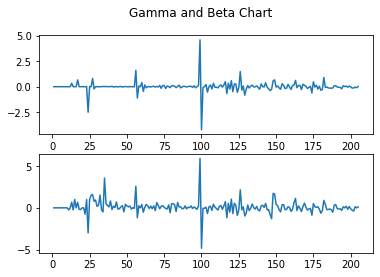

In [39]:
def calc_gamma(r0, r1, q, uq):
    if q+uq != 0:
        return (r1 - r0) / (q + uq)
    else:
        return 0

def calc_beta(q0, q1, uq0, uq1, r0, r1):
    if uq0 != 0:
        return (q1 - q0 + uq1 - uq0 + r1 - r0) / uq0
    else:
        return 0

def calc_ft(q0, q1, b, g, uq0):
    if b*uq0 != 0:
        return (q1 - q0 + g*q0) / b*uq0
    else:
        return 0

ft_prob = 0.6;
    
beta_t = []
gamma_t = []
ft_t = [ft_prob] * (total_days - 1);

for i in range(len(bd_data) - 1):
    gamma_t.append(calc_gamma(removed[i], removed[i+1], isolated[i], infected[i]-isolated[i]))
    beta_t.append(calc_beta(isolated[i], isolated[i+1], infected[i]-isolated[i], infected[i+1]-isolated[i+1], removed[i], removed[i+1]))


days = np.arange(1, total_days).tolist()
    
name, chart = plt.subplots(2)
name.suptitle('Gamma and Beta Chart')
chart[0].plot(days, gamma_t)
chart[1].plot(days, beta_t)

print(len(days)) #Total: 205

227 207 227 207 207


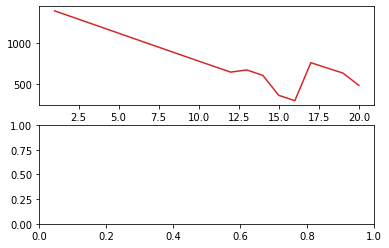

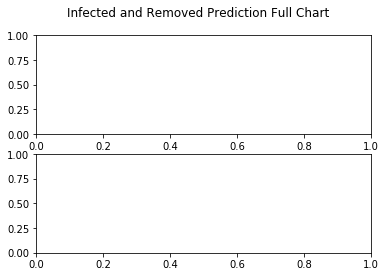

In [44]:
def convert(arr):
    res = []
    for i in range(len(arr)):
        res.append([arr[i]])
    return res

days = convert(np.arange(1, total_days).tolist())
beta_model = Ridge().fit(days, convert(beta_t))
gamma_model = Ridge().fit(days, convert(gamma_t))
ft_model = Ridge().fit(days, convert(ft_t))


days_test = []
test_days = 20 
for day in range(total_days + 1, total_days + test_days + 1):
    days_test.append(np.array([[day]]))

prob_beta = [beta_t[len(beta_t)-1]]
prob_gamma = [gamma_t[len(gamma_t)-1]]
prob_ft = [ft_t[len(ft_t)-1]]

for i in range(test_days):
    prob_beta.append(beta_model.predict(days_test[i])[0][0])
    # print(gamma_model.predict(days_test[i])[0][0])
    prob_gamma.append(gamma_model.predict(days_test[i])[0][0])
    prob_ft.append(ft_model.predict(days_test[i])[0][0])

def super_prediction(prob_beta, prob_gamma, prob_ft):
    last_iso = isolated[(len(isolated) - 1)] 
    last_un_iso = infected[len(infected) - 1] - last_iso
    last_removed = removed[len(removed) - 1]

    new_iso_count = []
    new_uniso_count = []
    new_removed_count = []
    
    for i in range(test_days):
        # current_infected = (1 + prob_beta[i] - prob_gamma[i]) * last_infected
        # current_removed = last_removed + (prob_gamma[i] * last_infected)
        # new_infected_count.append(current_infected)
        # new_removed_count.append(current_removed)
        # last_infected = copy.deepcopy(current_infected)
        # last_removed = copy.deepcopy(current_removed)

        cur_iso = prob_ft[i]*prob_beta[i]*last_un_iso - gamma_t[i]*last_iso + last_iso
        cur_un_iso = last_un_iso * (1 + (1 - prob_ft[i])*prob_beta[i] - prob_gamma[i])
        new_iso_count.append(cur_iso)
        new_uniso_count.append(cur_un_iso)
        last_iso = copy.deepcopy(cur_iso)
        last_un_iso = copy.deepcopy(cur_un_iso)
    
    return [new_iso_count, new_uniso_count, new_removed_count]

pred_iso, pred_uniso, pred_removed = super_prediction(prob_beta, prob_gamma, prob_ft)

def get_infected(iso, uniso):
    infected = []
    for i in range(len(iso)): 
        infected.append(iso[i] + uniso[i])
    return infected

pred_infected = get_infected(pred_iso, pred_uniso)
days = np.arange(1, test_days + 1).tolist()
name, chart = plt.subplots(2)
# name.suptitle('Infected and Removed Prediction Chart')
chart[0].plot(days, pred_infected, 'tab:red')
# chart[1].plot(days, pred_removed, 'tab:orange')

# Complete Chart

days = np.arange(1,  test_days + 1 + len(infected)).tolist()
name, chart = plt.subplots(2)
name.suptitle('Infected and Removed Prediction Full Chart')
# chart[0].plot(days, infected + pred_infected, 'tab:red')
# chart[1].plot(days, removed + pred_removed, 'tab:orange')


__inf = infected+get_infected(pred_iso, pred_uniso)
__iso = isolated + pred_iso
__rem = removed+pred_removed


# chart[0].plot(days, __inf, 'tab:red')
# chart[1].plot(days, __iso, 'tab:orange')

print(len(days), len(__rem), len(__iso), len(infected), len(removed))

